In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import models, transforms
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os
import glob
import time
import copy
import cv2
import json

import json
import numpy as np
import cv2
from pathlib import Path
from typing import Dict, List, Tuple
import torch
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2

from torchvision import models
import torch.nn as nn
import time
import os

import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import cv2
from pathlib import Path

### Dataset Preparation

we have total 512 images, 103 are test
given: train_test_split.json,
 instances_default.json (COCO Style)

primary challenge: train_test_split.json uses filename. instances_default.json uses integer_id's to link images with annotations.

solution:

* parse images in instances_default to create a dict {(filename:id)}
* For each split (train/test), identify which image_ids belong to that split using your lookup table. Then, extract all objects from the annotations list that match those image_ids.

second challenge: we need to scale both the image and the bounding box and the coordinates by the same ratio.


Pipeline:

1. Class Dataset Initialization:

    * Load both JSON files.
    * Construct the split-specific list of image metadata and corresponding annotations.

2. __getitem__(index) Logic:

    * Load image i using OpenCV.

    * Apply geometric transforms (Resize/Crop).

    * Transform the bbox or mask to match the new image dimensions.

    * Apply intensity transforms (To Tensor, Normalize).

    * Return the image tensor and a dictionary containing labels and coordinates.

https://blog.roboflow.com/how-to-use-albumentations/

In [87]:
class SemanticSegmentationDataset(Dataset):
    """
    Dataset for binary semantic segmentation (person vs background).
    All instance polygons for an image are merged into one binary mask.

    Returns per sample:
        image   : Tensor[3, H, W]  – normalised RGB
        mask    : Tensor[H, W]     – 0 = background, 1 = person  (LongTensor)
        image_id: int
    """

    def __init__(
        self,
        images_dir: str,
        annotations_file: str,
        split_file: str,
        split: str = 'train',
        img_size: Tuple[int, int] = (512, 512),
        augment: bool = True,
    ):
        self.images_dir = Path(images_dir)
        self.img_size   = img_size
        self.augment    = augment and (split == 'train')

        with open(annotations_file) as f:
            coco = json.load(f)
        with open(split_file) as f:
            split_data = json.load(f)

        # id <-> filename maps (built from annotations - ground truth)
        self.id_to_filename = {img['id']: img['file_name'] for img in coco['images']}
        self.filename_to_id = {v: k for k, v in self.id_to_filename.items()}

        # Only keep filenames that exist in the annotations file
        # Some split entries may be missing from instances_default.json
        all_filenames = split_data[split]
        missing = [f for f in all_filenames if f not in self.filename_to_id]
        if missing:
            print(f'[{split}] Warning: {len(missing)} filename(s) in split not '
                  f'found in annotations and will be skipped: {missing[:5]}'
                  f'{"..." if len(missing) > 5 else ""}')
        self.image_filenames = [f for f in all_filenames if f in self.filename_to_id]

        # Group annotations by image_id for images in this split only
        split_ids = {
            self.filename_to_id[f]
            for f in self.image_filenames
            if f in self.filename_to_id
        }
        self.anns_by_image: Dict[int, List[Dict]] = {}
        for ann in coco['annotations']:
            iid = ann['image_id']
            if iid in split_ids:
                self.anns_by_image.setdefault(iid, []).append(ann)

        self.transform = self._build_transforms()

    def _build_transforms(self):
        if self.augment:
            return A.Compose([
                A.Resize(*self.img_size),
                # A.HorizontalFlip(p=0.5),
                A.RandomBrightnessContrast(0.2, 0.2, p=0.5),
                # A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1,
                #                    rotate_limit=15, p=0.5),
                # A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),
                A.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225]),
                ToTensorV2(),
            ])
        else:
            return A.Compose([
                A.Resize(*self.img_size),
                A.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225]),
                ToTensorV2(),
            ])

    def _polygons_to_semantic_mask(
        self,
        annotations: List[Dict],
        height: int,
        width: int,
    ) -> np.ndarray:
        """Merge all instance polygons into one binary mask (0/1)."""
        mask = np.zeros((height, width), dtype=np.uint8)
        for ann in annotations:
            for polygon in ann['segmentation']:
                pts = np.array(polygon).reshape(-1, 2).astype(np.int32)
                cv2.fillPoly(mask, [pts], 1)
        return mask

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx: int) -> Dict:
        filename = self.image_filenames[idx]
        image_id = self.filename_to_id[filename]

        image = cv2.imread(str(self.images_dir / filename))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        h, w  = image.shape[:2]

        annotations = self.anns_by_image.get(image_id, [])
        mask = self._polygons_to_semantic_mask(annotations, h, w)

        out   = self.transform(image=image, mask=mask)
        image = out['image']        # Tensor[3, H, W]  float32
        mask  = out['mask'].long()  # Tensor[H, W]     int64

        return {'image': image, 'mask': mask, 'image_id': image_id}

In [88]:
def collate_fn(batch: List[Dict]) -> Dict:
    """All masks are [H,W] – simple stack, no custom logic needed."""
    return {
        'images':    torch.stack([b['image'] for b in batch]),  # [B, 3, H, W]
        'masks':     torch.stack([b['mask']  for b in batch]),  # [B, H, W]
        'image_ids': [b['image_id'] for b in batch],
    }

In [ ]:
def create_dataloaders(
    images_dir: str,
    annotations_file: str,
    split_file: str,
    img_size: Tuple[int, int] = (512, 512),
    batch_size: int = 8,
    num_workers: int = 0,   
) -> Tuple[DataLoader, DataLoader]:

    pin = torch.cuda.is_available()  # pin_memory not supported on MPS

    train_ds = SemanticSegmentationDataset(
        images_dir, annotations_file, split_file,
        split='train', img_size=img_size, augment=True,
    )
    test_ds = SemanticSegmentationDataset(
        images_dir, annotations_file, split_file,
        split='test', img_size=img_size, augment=False,
    )

    train_loader = DataLoader(
        train_ds, batch_size=batch_size, shuffle=True,
        num_workers=num_workers, collate_fn=collate_fn, pin_memory=pin,
    )
    test_loader = DataLoader(
        test_ds, batch_size=batch_size, shuffle=False,
        num_workers=num_workers, collate_fn=collate_fn, pin_memory=pin,
    )
    return train_loader, test_loader

In [ ]:
# Configuration
IMAGES_DIR = "../dataset/q2/data/images"
ANNOTATIONS_FILE = "../dataset/q2/data/annotations/instances_default.json"
SPLIT_FILE = "../dataset/q2/train_test_split.json"
IMG_SIZE = (512, 512)  # Suitable for ResNet18
BATCH_SIZE = 8

# Create dataloaders
train_loader, test_loader = create_dataloaders(
    images_dir=IMAGES_DIR,
    annotations_file=ANNOTATIONS_FILE,
    split_file=SPLIT_FILE,
    img_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    num_workers=0 
)

# Test the dataloader
print(f"Train dataset size: {len(train_loader.dataset)}")
print(f"Test dataset size: {len(test_loader.dataset)}")

batch = next(iter(train_loader))
print(f"images : {batch['images'].shape}")          # [8, 3, 512, 512]
print(f"masks  : {batch['masks'].shape}")           # [8, 512, 512]
print(f"unique mask values: {batch['masks'].unique()}")  # tensor([0, 1])

[train] Warning: 15 filename(s) in split not found in annotations and will be skipped: ['251.jpg', '326.jpg', '218.jpg', '145.jpg', '489.jpg']...
[test] Warning: 1 filename(s) in split not found in annotations and will be skipped: ['338.jpg']
Train dataset size: 394
Test dataset size: 102
images : torch.Size([8, 3, 512, 512])
masks  : torch.Size([8, 512, 512])
unique mask values: tensor([0, 1])


#### Testing Dataset preparation:

In [91]:
def denormalize_image(image_tensor: torch.Tensor) -> np.ndarray:
    """Undo ImageNet normalisation and return a [H, W, 3] uint8 array."""
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std  = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    img  = torch.clamp(image_tensor.cpu() * std + mean, 0, 1)
    return img.permute(1, 2, 0).numpy()


def visualize_batch(batch: dict, num_samples: int = 4, save_path: str = None):
    """
    Two columns per sample:
      Left  - original image
      Right - image with binary semantic mask overlaid in red
    """
    images  = batch['images']   # [B, 3, H, W]
    masks   = batch['masks']    # [B, H, W]
    n       = min(num_samples, len(images))

    fig, axes = plt.subplots(n, 2, figsize=(10, 5 * n))
    if n == 1:
        axes = axes.reshape(1, -1)

    for i in range(n):
        img_np  = denormalize_image(images[i])          # [H, W, 3]
        mask_np = masks[i].cpu().numpy().astype(bool)   # [H, W]

        # Col 0 – raw image
        axes[i, 0].imshow(img_np)
        axes[i, 0].set_title(f'Image {i}')
        axes[i, 0].axis('off')

        # Col 1 – image + mask overlay
        overlay = img_np.copy()
        overlay[mask_np] = overlay[mask_np] * 0.4 + np.array([1, 0, 0]) * 0.6
        axes[i, 1].imshow(overlay)
        coverage = mask_np.mean() * 100
        axes[i, 1].set_title(f'Mask overlay  ({coverage:.1f}% person)')
        axes[i, 1].axis('off')

    plt.suptitle('Semantic Segmentation - Preprocessing Verification',
                 fontsize=13, y=1.01)
    plt.tight_layout()

    if save_path:
        fig.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f'  ✓ Visualization saved → {save_path}')

    return fig


def print_split_statistics(dataloader, split_name: str):
    """Print pixel-level statistics for the split."""
    print(f"\n{'='*55}")
    print(f"  {split_name.upper()} STATISTICS")
    print(f"{'='*55}")
    print(f"  Images          : {len(dataloader.dataset)}")

    total_pixels   = 0
    person_pixels  = 0
    empty_images   = 0

    for batch in dataloader:
        masks = batch['masks']          # [B, H, W]  int64
        total_pixels  += masks.numel()
        person_pixels += masks.sum().item()
        empty_images  += (masks.sum(dim=(1, 2)) == 0).sum().item()

    bg_pixels = total_pixels - person_pixels
    print(f"  Person pixels   : {person_pixels:,}  ({person_pixels/total_pixels*100:.1f}%)")
    print(f"  BG pixels       : {bg_pixels:,}  ({bg_pixels/total_pixels*100:.1f}%)")
    print(f"  Images w/o mask : {empty_images}")
    print(f"  Class balance   : 1 : {bg_pixels/max(person_pixels,1):.1f}  "
          f"(bg : person)")
    print(f"{'='*55}")


# ── main test ─────────────────────────────────────────────────────────────────

def test_preprocessing(
    images_dir: str,
    annotations_file: str,
    split_file: str,
    img_size: tuple = (512, 512),
    batch_size: int = 4,
):
    print("Creating dataloaders...")
    try:
        # num_workers=0: required on macOS/Windows – see module docstring
        train_loader, test_loader = create_dataloaders(
            images_dir=images_dir,
            annotations_file=annotations_file,
            split_file=split_file,
            img_size=img_size,
            batch_size=batch_size,
            num_workers=0,
        )
    except Exception:
        import traceback; traceback.print_exc()
        return None, None

    print(f"  Train loader : {len(train_loader.dataset)} images")
    print(f"  Test  loader : {len(test_loader.dataset)} images")

    # Dataset statistics
    print_split_statistics(train_loader, 'train')
    print_split_statistics(test_loader,  'test')

    # Batch shape check
    print("\nLoading a train batch...")
    batch = next(iter(train_loader))
    print(f"  images shape : {batch['images'].shape}")   # [B, 3, H, W]
    print(f"  masks  shape : {batch['masks'].shape}")    # [B, H, W]
    print(f"  mask values  : {batch['masks'].unique().tolist()}")  # [0, 1]
    assert batch['images'].shape == torch.Size([batch_size, 3, *img_size]), \
        "Unexpected image shape!"
    assert batch['masks'].shape  == torch.Size([batch_size, *img_size]), \
        "Unexpected mask shape!"
    assert set(batch['masks'].unique().tolist()).issubset({0, 1}), \
        "Mask contains values other than 0 and 1!"

    # Visualize
    print("\nGenerating visualization...")
    out_path = Path('preprocessing_visualization.png')
    visualize_batch(batch, num_samples=min(4, batch_size),
                    save_path=str(out_path))
    plt.close()

    print("\nAll checks passed - preprocessing pipeline is ready!")
    return train_loader, test_loader

In [92]:
train_loader, test_loader = test_preprocessing(
    images_dir=IMAGES_DIR,
    annotations_file=ANNOTATIONS_FILE,
    split_file=SPLIT_FILE,
    img_size=IMG_SIZE,
    batch_size=4,
)

Creating dataloaders...
[train] Warning: 15 filename(s) in split not found in annotations and will be skipped: ['251.jpg', '326.jpg', '218.jpg', '145.jpg', '489.jpg']...
[test] Warning: 1 filename(s) in split not found in annotations and will be skipped: ['338.jpg']
  Train loader : 394 images
  Test  loader : 102 images

  TRAIN STATISTICS
  Images          : 394
  Person pixels   : 1,924,041  (1.9%)
  BG pixels       : 101,360,695  (98.1%)
  Images w/o mask : 0
  Class balance   : 1 : 52.7  (bg : person)

  TEST STATISTICS
  Images          : 102
  Person pixels   : 509,792  (1.9%)
  BG pixels       : 26,228,896  (98.1%)
  Images w/o mask : 0
  Class balance   : 1 : 51.5  (bg : person)

Loading a train batch...
  images shape : torch.Size([4, 3, 512, 512])
  masks  shape : torch.Size([4, 512, 512])
  mask values  : [0, 1]

Generating visualization...
  ✓ Visualization saved → preprocessing_visualization.png

All checks passed - preprocessing pipeline is ready!


Error: train_test_split.json contains filenames (like 356.jpg) that simply don't appear in the images list inside instances_default.json

In [93]:
if torch.backends.mps.is_available():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(f"Using device: {device}")

Using device: mps


### Loading Resnet Pretrained Model

In [95]:
resnet18_pretrained = models.resnet18(weights = models.ResNet18_Weights.IMAGENET1K_V1)

In [96]:
for name, module in resnet18_pretrained.named_modules():
    print(name, module)

 ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
 

In [97]:
for name, child in resnet18_pretrained.named_children():
    print(f"name: {name}")
    print(child)

name: conv1
Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
name: bn1
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
name: relu
ReLU(inplace=True)
name: maxpool
MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
name: layer1
Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64,

### Train Helper

In [98]:
eps = 1e-6

In [99]:
def calculate_dice_loss(logits, mask):
    probs = torch.sigmoid(logits)

    batch_size = probs.size(0)
    probs_flattened = probs.view(batch_size, -1)
    masks_flattened = mask.view(batch_size, -1)

    intersection = torch.sum(probs_flattened * masks_flattened, dim = 1)
    union = torch.sum(probs_flattened, dim = 1) + torch.sum(masks_flattened, dim = 1)
    dice = (2* intersection + eps) / (union + eps)

    loss = 1 - dice

    return loss.mean()

In [ ]:
def train_model(model, optimizer, num_epochs = 15):
    since = time.time()
    train_loss = []
    train_miou = []

    for epoch in range(num_epochs):
        model.train()
        print('=' *30)
        print(f'Epoch {epoch + 1}/{num_epochs}')

        running_loss = 0
        # running_miou = 0.0
        running_tp = running_fp = running_fn = running_tn = 0
        for batch in train_loader:
            optimizer.zero_grad()

            imgs  = batch['images'].to(device)
            masks = batch['masks'].to(device).float()

            logits = model(imgs)
            loss = calculate_dice_loss(logits, masks)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * imgs.size(0)

            with torch.no_grad():
                preds = (torch.sigmoid(logits.squeeze(1)) >= 0.5).float()

                running_tp += torch.sum(preds       * masks      ).item()
                running_fp += torch.sum(preds       * (1 - masks)).item()
                running_fn += torch.sum((1 - preds) * masks      ).item()
                running_tn += torch.sum((1 - preds) * (1 - masks)).item()

        epoch_loss  = running_loss / len(train_loader.dataset)
        train_loss.append(epoch_loss)

        iou_person = running_tp / (running_tp + running_fp + running_fn + eps)
        iou_bg     = running_tn / (running_tn + running_fp + running_fn + eps)
        epoch_miou = (iou_person + iou_bg) / 2
        train_miou.append(epoch_miou)

        print(f"Train Loss: {epoch_loss:.4f}, Train mIoU: {epoch_miou * 100:.2f}%")

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

    return model, train_loss, train_miou

### Quantitative Analysis Helper

In [ ]:
def evaluate_model(model, dataloader, device, eps=1e-6):
    model.eval()
    tp = fp = fn = tn = 0

    with torch.no_grad():
        for batch in dataloader:
            imgs  = batch['images'].to(device)
            masks = batch['masks'].float().to(device)   # [B, H, W]

            logits = model(imgs)                        # [B, 1, H, W]
            preds  = (torch.sigmoid(logits.squeeze(1)) >= 0.5).float()

            tp += torch.sum(preds       * masks      ).item()
            fp += torch.sum(preds       * (1 - masks)).item()
            fn += torch.sum((1 - preds) * masks      ).item()
            tn += torch.sum((1 - preds) * (1 - masks)).item()

    accuracy   = (tp + tn) / (tp + tn + fp + fn + eps)
    iou_person = tp / (tp + fp + fn + eps)
    iou_bg     = tn / (tn + fn + fp + eps)
    mIoU       = (iou_person + iou_bg) / 2

    print(f"\n{'='*50}")
    print(f"  QUANTITATIVE RESULTS")
    print(f"{'='*50}")
    print(f"  Pixel Accuracy   : {accuracy  * 100:.2f}%")
    print(f"  IoU (person)     : {iou_person* 100:.2f}%")
    print(f"  IoU (background) : {iou_bg    * 100:.2f}%")
    print(f"  mIoU             : {mIoU      * 100:.2f}%")
    print(f"{'='*50}")
    print(f"  Confusion Matrix")
    print(f"    TP={tp:,.0f}  FP={fp:,.0f}")
    print(f"    FN={fn:,.0f}  TN={tn:,.0f}")
    print(f"{'='*50}\n")

    return dict(accuracy=accuracy, iou_person=iou_person,
                iou_background=iou_bg, mIoU=mIoU,
                tp=tp, fp=fp, fn=fn, tn=tn)

### Qualitative Analysis Helper

In [102]:
def plot_training_history(train_loss, train_miou):
    # Convert any MPS tensors back to standard Python floats
    train_loss = [t.item() if torch.is_tensor(t) else t for t in train_loss]
    train_miou = [t.item() * 100  if torch.is_tensor(t) else t for t in train_miou]
    
    epochs = range(1, len(train_loss) + 1)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    # Loss Plot
    ax1.plot(epochs, train_loss, 'b-o', label='Train Loss')
    ax1.set_title('Loss History')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Accuracy Plot
    ax2.plot(epochs, train_miou, 'b-o', label='Train mIoU')
    ax2.set_title('mIoU History')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('mIoU (%)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

In [ ]:
def extract_boundary(mask_np: np.ndarray, thickness: int = 3) -> np.ndarray:
    """
    Morphological boundary = dilation - erosion of binary mask.
    Returns a boolean array of the same shape.
    """
    kernel   = cv2.getStructuringElement(
        cv2.MORPH_ELLIPSE, (thickness * 2 + 1, thickness * 2 + 1)
    )
    dilated  = cv2.dilate(mask_np, kernel)
    eroded   = cv2.erode (mask_np, kernel)
    return (dilated - eroded).astype(bool)

In [148]:
def qualitative_evaluation(
    model,
    dataloader,
    device,
    num_samples: int = 4,
    save_path: str = "../outputs/qualitative_evaluation.png",
):
    """
    4-column plot for each sample:
      Col 0 – Original image
      Col 1 – Ground truth mask
      Col 2 – Predicted mask
      Col 3 – Boundary sharpness overlay
                green = GT boundary
                red   = predicted boundary
                yellow= overlap (correct boundary)
    """
    model.eval()
    collected = []   # list of (img_np, gt_np, pred_np)

    with torch.no_grad():
        for batch in dataloader:
            imgs  = batch['images'].to(device)
            masks = batch['masks'].float().to(device)

            logits = model(imgs)
            preds  = (torch.sigmoid(logits.squeeze(1)) >= 0.5).float()

            for i in range(len(imgs)):
                if len(collected) >= num_samples:
                    break
                collected.append((
                    denormalize_image(imgs[i].cpu()),        # [H,W,3]
                    masks[i].cpu().numpy().astype(np.uint8), # [H,W]
                    preds[i].cpu().numpy().astype(np.uint8), # [H,W]
                ))
            if len(collected) >= num_samples:
                break

    n    = len(collected)
    fig, axes = plt.subplots(n, 4, figsize=(20, 5 * n))
    if n == 1:
        axes = axes.reshape(1, -1)

    col_titles = [
        'Original Image',
        'Ground Truth Mask',
        'Predicted Mask',
        'Boundary Sharpness\n(blue=GT  orange=pred  white=match)',
    ]
    for j, title in enumerate(col_titles):
        axes[0, j].set_title(title, fontsize=11, fontweight='bold')

    for i, (img_np, gt_np, pred_np) in enumerate(collected):

        # ── col 0: original image ──────────────────────────────────────────
        axes[i, 0].imshow(img_np)
        axes[i, 0].axis('off')

        # ── col 1: ground truth mask ───────────────────────────────────────
        gt_overlay = img_np.copy()
        gt_overlay[gt_np.astype(bool)] = (
            # gt_overlay[gt_np.astype(bool)] * 0.4 + np.array([0.2, 0.8, 0.2]) * 0.6
            gt_overlay[gt_np.astype(bool)] * 0.4 + np.array([0.0, 0.5, 1.0]) * 0.6
        )
        axes[i, 1].imshow(gt_overlay)
        axes[i, 1].axis('off')

        # ── col 2: predicted mask ──────────────────────────────────────────
        pred_overlay = img_np.copy()
        pred_overlay[pred_np.astype(bool)] = (
            # pred_overlay[pred_np.astype(bool)] * 0.4 + np.array([0.9, 0.2, 0.2]) * 0.6
            pred_overlay[pred_np.astype(bool)] * 0.4 + np.array([1.0, 0.5, 0.0]) * 0.6
            # pred_overlay[pred_np.astype(bool)] * 0.4 + np.array([1.0, 0.0, 1.0]) * 0.6
        )

        # per-image IoU annotation
        eps    = 1e-6
        tp_i   = np.sum(pred_np * gt_np)
        fp_i   = np.sum(pred_np * (1 - gt_np))
        fn_i   = np.sum((1 - pred_np) * gt_np)
        iou_i  = tp_i / (tp_i + fp_i + fn_i + eps)
        axes[i, 2].imshow(pred_overlay)
        axes[i, 2].set_xlabel(f'IoU = {iou_i*100:.1f}%', fontsize=10)
        axes[i, 2].axis('off')

        # ── col 3: boundary sharpness ──────────────────────────────────────
        gt_boundary   = extract_boundary(gt_np)
        pred_boundary = extract_boundary(pred_np)

        boundary_vis  = img_np.copy()

        # Blue = GT boundary only
        gt_only = gt_boundary & ~pred_boundary
        boundary_vis[gt_only] = (
            boundary_vis[gt_only] * 0.2 + np.array([0.0, 0.5, 1.0]) * 0.8
        )

        # Orange = predicted boundary only
        pred_only = pred_boundary & ~gt_boundary
        boundary_vis[pred_only] = (
            boundary_vis[pred_only] * 0.2 + np.array([1.0, 0.5, 0.0]) * 0.8
        )

        # White = both overlap
        both = gt_boundary & pred_boundary
        boundary_vis[both] = (
            boundary_vis[both] * 0.2 + np.array([1.0, 1.0, 1.0]) * 0.8
        )

        axes[i, 3].imshow(boundary_vis)
        axes[i, 3].axis('off')

        # boundary accuracy for this image
        if gt_boundary.sum() > 0:
            b_acc = both.sum() / (gt_boundary.sum() + eps)
            axes[i, 3].set_xlabel(
                f'Boundary overlap = {b_acc*100:.1f}%', fontsize=10
            )

    # legend for boundary plot
    legend_patches = [
        mpatches.Patch(color='blue',  label='GT boundary only'),
        mpatches.Patch(color='orange',    label='Pred boundary only'),
        mpatches.Patch(color='white', label='Correct boundary'),
    ]
    fig.legend(handles=legend_patches, loc='lower center',
               ncol=3, fontsize=10, bbox_to_anchor=(0.75, 0.0))

    plt.suptitle('Qualitative Segmentation Evaluation', fontsize=14,
                 fontweight='bold', y=1.01)
    plt.tight_layout()

    if save_path:
        fig.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Qualitative plot saved → {save_path}")

    plt.show()
    return fig

In [136]:
def run_full_evaluation(model, test_loader, device, num_qualitative_samples: int = 4, save_dir: str = "../outputs/q2", save_file_name = "Q2_qualitative_evaluation.png"):
    save_dir = Path(save_dir)

    print("Running quantitative evaluation...")
    metrics = evaluate_model(model, test_loader, device)

    print("Running qualitative evaluation...")
    qualitative_evaluation(
        model, test_loader, device,
        num_samples=num_qualitative_samples,
        save_path=str(save_dir / save_file_name),
    )

    return metrics

In [104]:
SAVED_MODELS_PATH = '../models'

### Part 1: Single Stage Upsampling

In [105]:
class SemanticSegmentationModel(nn.Module):
    def __init__(self, encoder, decoder, seg_head = None):
        super(SemanticSegmentationModel, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.seg_head = seg_head if seg_head is not None else nn.Identity()
    
    def forward(self, img):
        out = self.encoder(img)
        out = self.decoder(out)
        out = self.seg_head(out)
        return out

In [106]:
# remove last two layers - avgpool and fc
layers = list(resnet18_pretrained.children())[:-2]
print(len(layers))

8


In [107]:
for layer in layers:
    print(f"layer: {layer}")

layer: Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
layer: BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
layer: ReLU(inplace=True)
layer: MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
layer: Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stri

In [108]:
segmentation_encoder = nn.Sequential(*layers)
# output: 512 x 16 x 16

To Freeze the encoder layers or not?? different LR for encoder, different for decoder. 

In [109]:
model_Q1 = SemanticSegmentationModel(
    encoder=segmentation_encoder,
    decoder=nn.ConvTranspose2d(in_channels=512, out_channels=1, kernel_size=64, stride=32, padding=16,output_padding=0)
    )

model_Q1.to(device)

SemanticSegmentationModel(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_r

initialize decoder weights? randomly or??

In [110]:
decoder_lr = 0.001
encoder_lr = 0.00001

params = [
    {"params": model_Q1.encoder.parameters(), "lr": encoder_lr},
    {"params": list(model_Q1.decoder.parameters()) + list(model_Q1.seg_head.parameters()), "lr": decoder_lr}
]

In [111]:
optim = torch.optim.AdamW(params=params, weight_decay=1e-2)

In [112]:
for i, group in enumerate(optim.param_groups):
    print(f"Group {i} learning rate: {group['lr']}")

Group 0 learning rate: 1e-05
Group 1 learning rate: 0.001


In [113]:
print(f'Trainable parameters: {sum(p.numel() for p in model_Q1.parameters() if p.requires_grad)}')

Trainable parameters: 13273665


In [114]:
for name, param in model_Q1.named_parameters():
    if param.device.type != 'mps':
        print(f"Layer {name} is on device: {param.device}")

In [115]:
model_Q1, train_loss, train_miou = train_model(model=model_Q1, optimizer=optim, num_epochs=15)

Epoch 1/15
Train Loss: 0.7457, Train mIoU: 50.42%
Epoch 2/15
Train Loss: 0.5080, Train mIoU: 65.92%
Epoch 3/15
Train Loss: 0.4163, Train mIoU: 70.28%
Epoch 4/15
Train Loss: 0.3736, Train mIoU: 72.51%
Epoch 5/15
Train Loss: 0.3486, Train mIoU: 73.89%
Epoch 6/15
Train Loss: 0.3286, Train mIoU: 75.03%
Epoch 7/15
Train Loss: 0.3133, Train mIoU: 75.92%
Epoch 8/15
Train Loss: 0.3000, Train mIoU: 76.73%
Epoch 9/15
Train Loss: 0.2878, Train mIoU: 77.49%
Epoch 10/15
Train Loss: 0.2782, Train mIoU: 78.11%
Epoch 11/15
Train Loss: 0.2687, Train mIoU: 78.70%
Epoch 12/15
Train Loss: 0.2603, Train mIoU: 79.27%
Epoch 13/15
Train Loss: 0.2538, Train mIoU: 79.69%
Epoch 14/15
Train Loss: 0.2460, Train mIoU: 80.23%
Epoch 15/15
Train Loss: 0.2394, Train mIoU: 80.66%
Training complete in 20m 8s


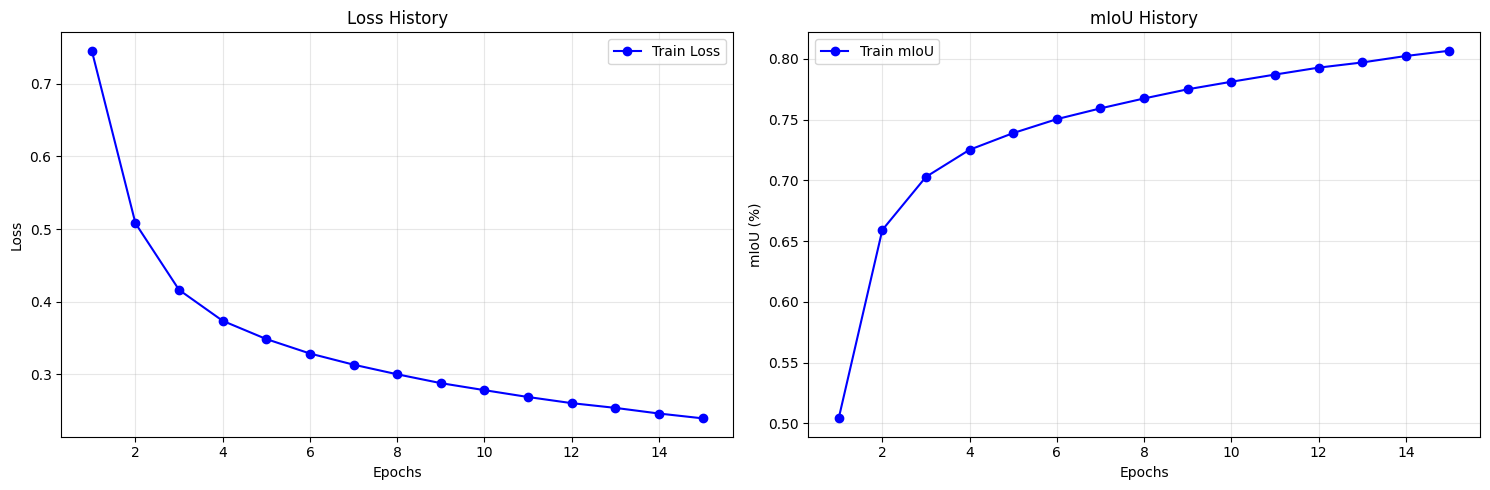

In [116]:
plot_training_history(train_loss= train_loss, train_miou=train_miou)

In [133]:
path = os.path.join(SAVED_MODELS_PATH, 'Q2_model_1.pth')
torch.save(model_Q1.state_dict(), path)

Running quantitative evaluation...

  QUANTITATIVE RESULTS
  Pixel Accuracy   : 98.87%
  IoU (person)     : 53.36%
  IoU (background) : 98.86%
  mIoU             : 76.11%
  Confusion Matrix
    TP=344,954  FP=136,733
    FN=164,838  TN=26,092,163

Running qualitative evaluation...
Qualitative plot saved → ../outputs/q2/qualitative_evaluation_1.png


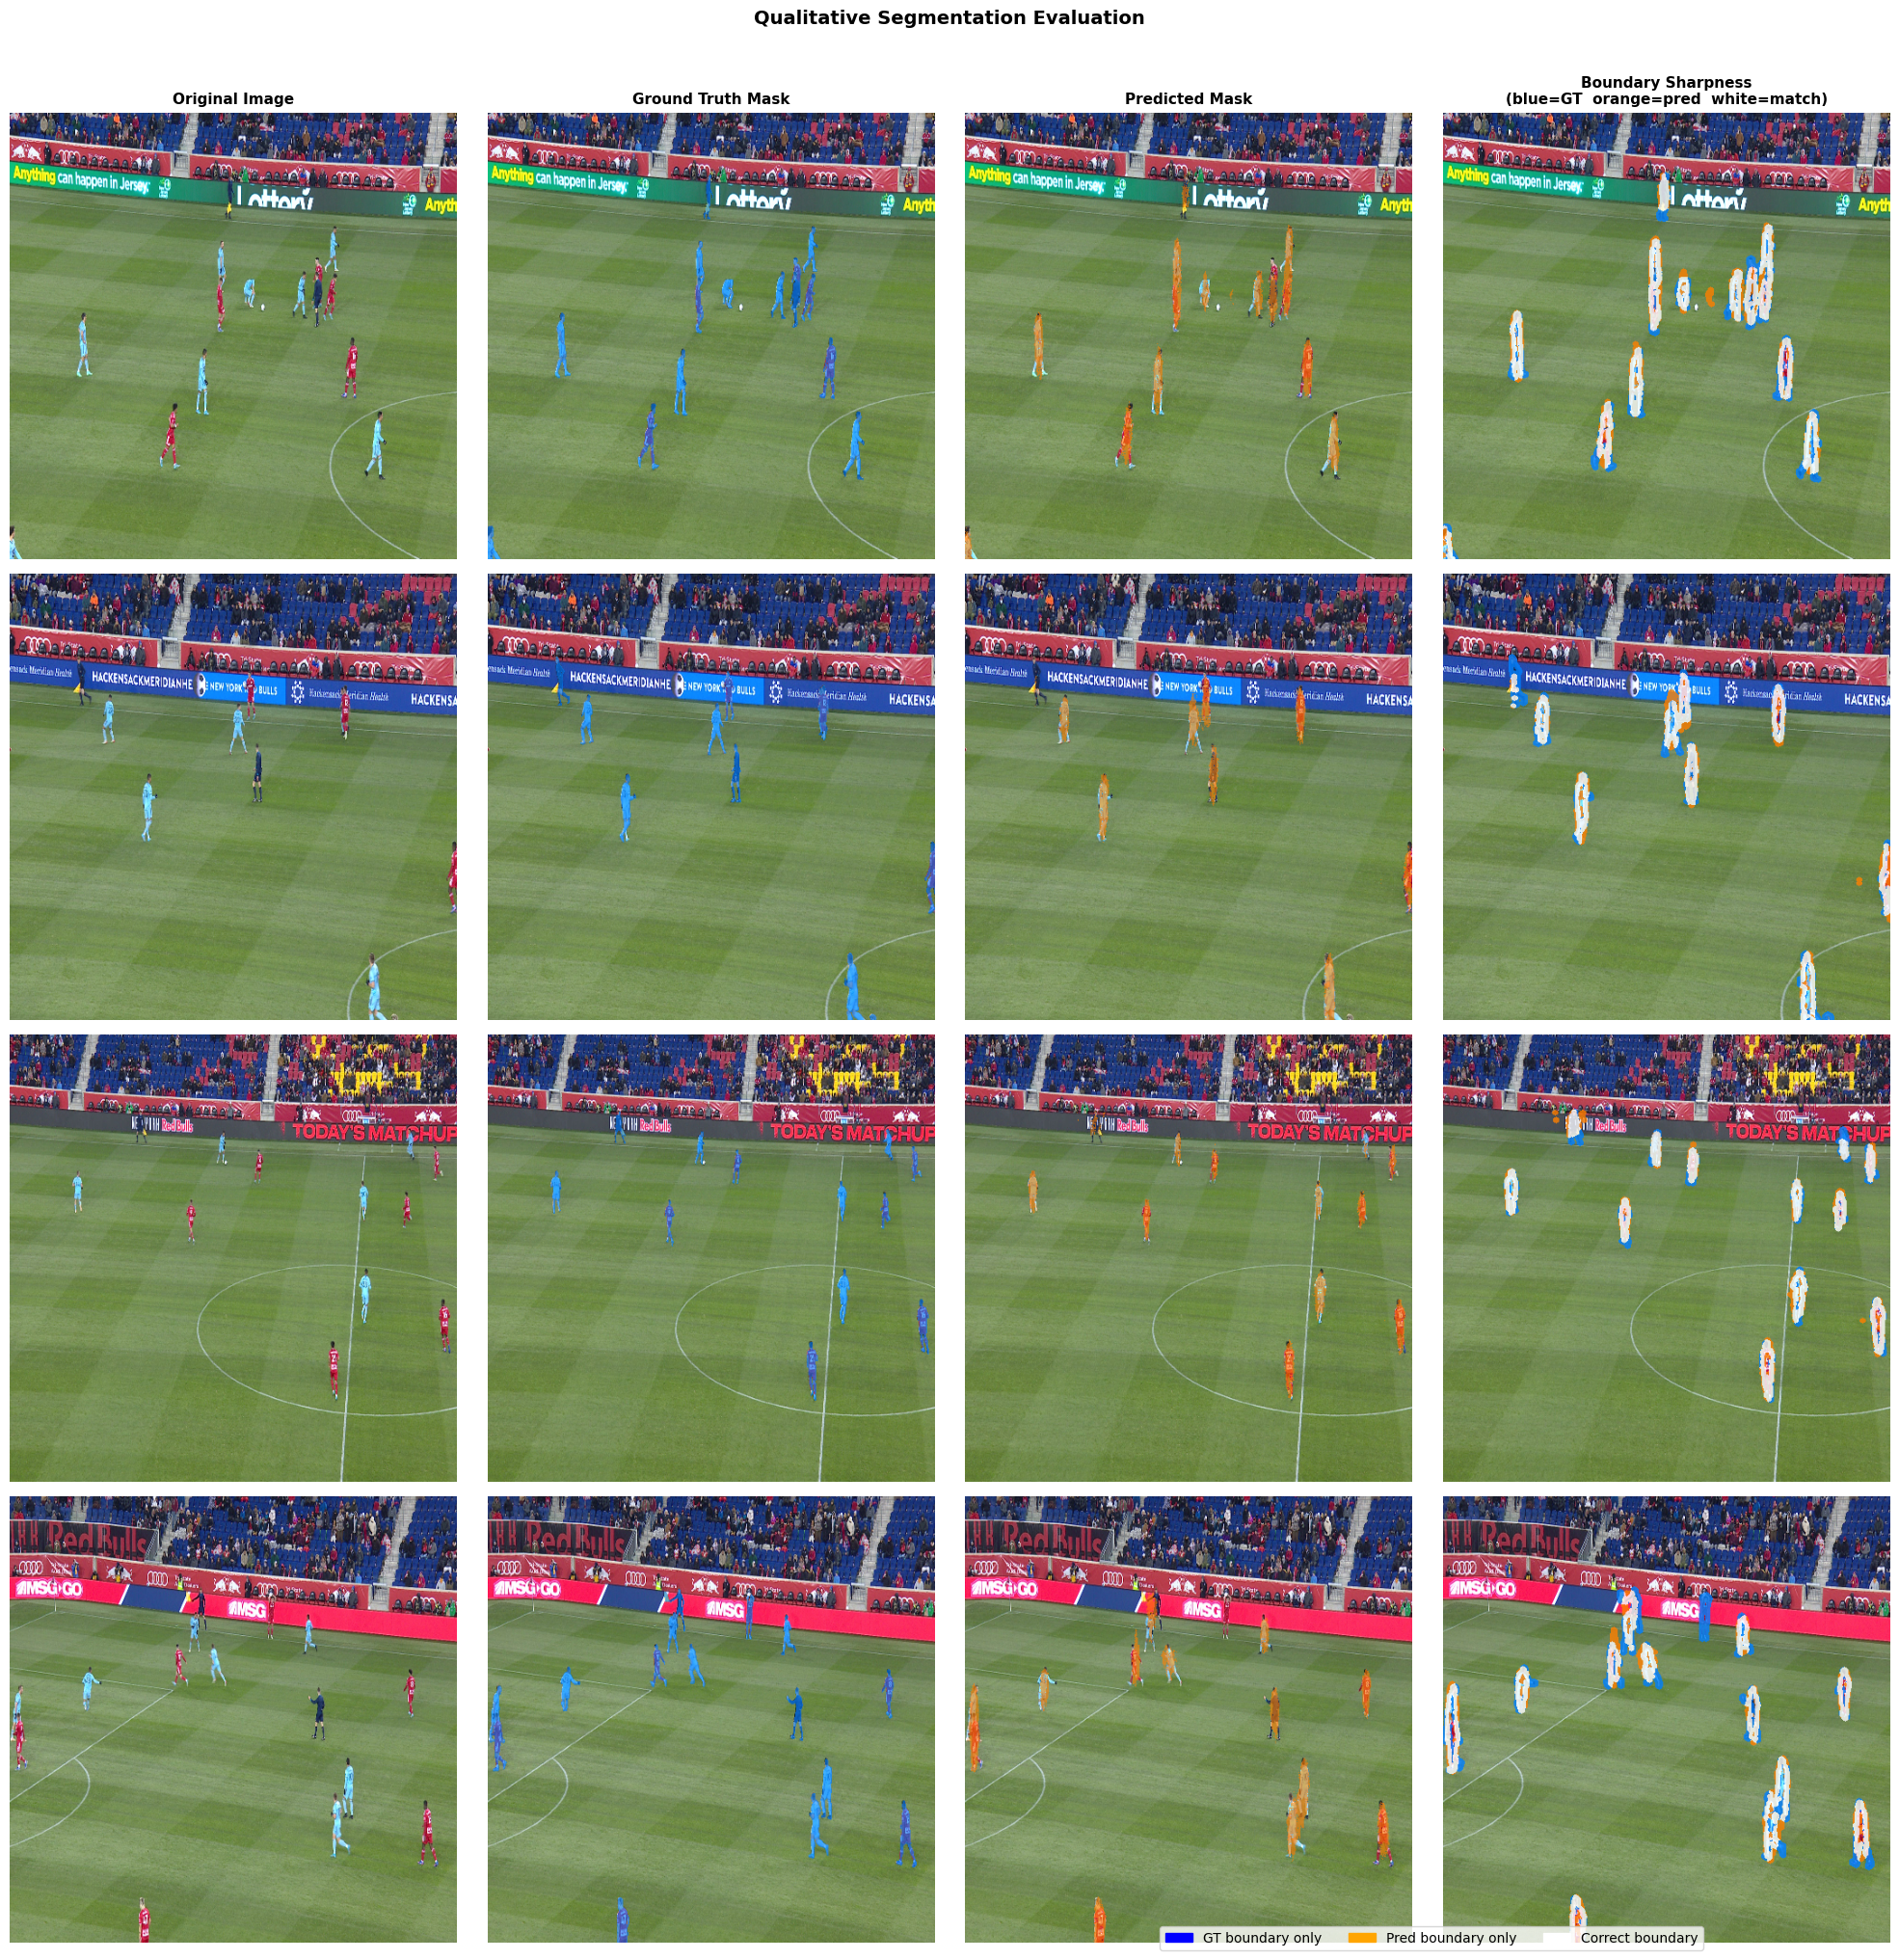

In [149]:
metrics = run_full_evaluation(model_Q1, test_loader, device, num_qualitative_samples=4, save_file_name="qualitative_evaluation_1.png")

### Part 2: Progressive Upsampling

In [119]:
class ResNetEncoderWithSkip(nn.Module):
    def __init__(self):
        super().__init__()

        base_model = models.resnet18(weights = models.ResNet18_Weights.IMAGENET1K_V1)

        self.conv1 = base_model.conv1
        self.bn1 = base_model.bn1
        self.relu = base_model.relu
        self.maxpool = base_model.maxpool
        self.layer1 = base_model.layer1 # 1/4 resolution
        self.layer2 = base_model.layer2 # 1/8 resolution
        self.layer3 = base_model.layer3 # 1/16 resolution
        self.layer4 = base_model.layer4 # 1/32 resolution
    
    def forward(self, x):
        skip_features = []

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        skip_features.append(x)         # 256x256 x 64 <- skip[0]

        x = self.maxpool(x)
        x = self.layer1(x)
        skip_features.append(x)         # 128x128 x 64 <- skip[1]

        x = self.layer2(x)
        skip_features.append(x)         # 64x64 x 128 <- skip[2]

        x = self.layer3(x)
        skip_features.append(x)         # 32x32 x 256 <- skip[3]

        x = self.layer4(x)              # 16×16  × 512 

        return x, skip_features

In [120]:
class DecoderProgressiveUpsamplingWithSkip(nn.Module):
    def __init__(self):
        super().__init__()
        self.up1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1,output_padding=1),   # 16×16×512 -> 32×32×256
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(inplace=True)
        )
        self.up2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=256 + 256, out_channels=128, kernel_size=3, stride=2, padding=1,output_padding=1),   # 32×32×256   + skip[3] (32×32×256) -> 64×64×128
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(inplace=True)
        )
        self.up3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128 + 128, out_channels=64, kernel_size=3, stride=2, padding=1,output_padding=1),    # 64×64×128   + skip[2] (64×64×128) -> 128×128×64
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(inplace=True)
        )
        self.up4 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=3, stride=2, padding=1,output_padding=1),     # 128×128×64 -> 256×256×64
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(inplace=True)
        )
        self.up5 = nn.ConvTranspose2d(in_channels=64, out_channels=1, kernel_size=3, stride=2, padding=1,output_padding=1)      # 256×256×64 -> 512×512×1

    def forward(self, x, skip_features):
        out = self.up1(x)                       # 32x32x256

        # skip connection 1: from layer 3 (32x32x256)
        out = torch.cat([out, skip_features[3]], dim=1)
        out = self.up2(out)                     # 64x64x128

        # skip connection 2: from layer 2 (64x64x128)
        out = torch.cat([out, skip_features[2]], dim=1)
        out = self.up3(out)                     # 128x128x64
        
        out = self.up4(out)                     # 256x256x64
        out = self.up5(out)                     # 512x512x1

        return out

In [121]:
class SemanticSegmentationModelWithSkip(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
    
    def forward(self, x):
        x, skip_features = self.encoder(x)
        out = self.decoder(x, skip_features)
        
        return out

In [122]:
encoder_skip = ResNetEncoderWithSkip()
decoder_skip = DecoderProgressiveUpsamplingWithSkip()

model_Q2 = SemanticSegmentationModelWithSkip(encoder=encoder_skip, decoder=decoder_skip)

model_Q2.to(device)

SemanticSegmentationModelWithSkip(
  (encoder): ResNetEncoderWithSkip(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e

In [123]:
decoder_lr = 0.001
encoder_lr = 0.00001

params = [
    {"params": model_Q2.encoder.parameters(), "lr": encoder_lr},
    {"params": model_Q2.decoder.parameters(),"lr": decoder_lr}
]

optim = torch.optim.AdamW(params=params, weight_decay=1e-2)

In [124]:
for i, group in enumerate(optim.param_groups):
    print(f"Group {i} learning rate: {group['lr']}")

Group 0 learning rate: 1e-05
Group 1 learning rate: 0.001


In [125]:
print(f'Trainable parameters: {sum(p.numel() for p in model_Q2.parameters() if p.requires_grad)}')

Trainable parameters: 13132417


In [126]:
for name, param in model_Q2.named_parameters():
    if param.device.type != 'mps':
        print(f"Layer {name} is on device: {param.device}")

In [127]:
# Test forward pass
dummy_input = torch.randn(2, 3, 512, 512).to(device)
output = model_Q2(dummy_input)
print(f"Input shape  : {dummy_input.shape}")  # [2, 3, 512, 512]
print(f"Output shape : {output.shape}")       # [2, 1, 512, 512]

Input shape  : torch.Size([2, 3, 512, 512])
Output shape : torch.Size([2, 1, 512, 512])


In [128]:
model_Q2, train_loss, train_miou = train_model(model=model_Q2, optimizer=optim, num_epochs=15)

Epoch 1/15
Train Loss: 0.5016, Train mIoU: 62.48%
Epoch 2/15
Train Loss: 0.1960, Train mIoU: 84.92%
Epoch 3/15
Train Loss: 0.1659, Train mIoU: 86.30%
Epoch 4/15
Train Loss: 0.1516, Train mIoU: 87.14%
Epoch 5/15
Train Loss: 0.1402, Train mIoU: 87.89%
Epoch 6/15
Train Loss: 0.1335, Train mIoU: 88.35%
Epoch 7/15
Train Loss: 0.1261, Train mIoU: 88.89%
Epoch 8/15
Train Loss: 0.1202, Train mIoU: 89.34%
Epoch 9/15
Train Loss: 0.1148, Train mIoU: 89.74%
Epoch 10/15
Train Loss: 0.1116, Train mIoU: 90.00%
Epoch 11/15
Train Loss: 0.1069, Train mIoU: 90.35%
Epoch 12/15
Train Loss: 0.1037, Train mIoU: 90.62%
Epoch 13/15
Train Loss: 0.0997, Train mIoU: 90.93%
Epoch 14/15
Train Loss: 0.0957, Train mIoU: 91.26%
Epoch 15/15
Train Loss: 0.0927, Train mIoU: 91.51%
Training complete in 11m 38s


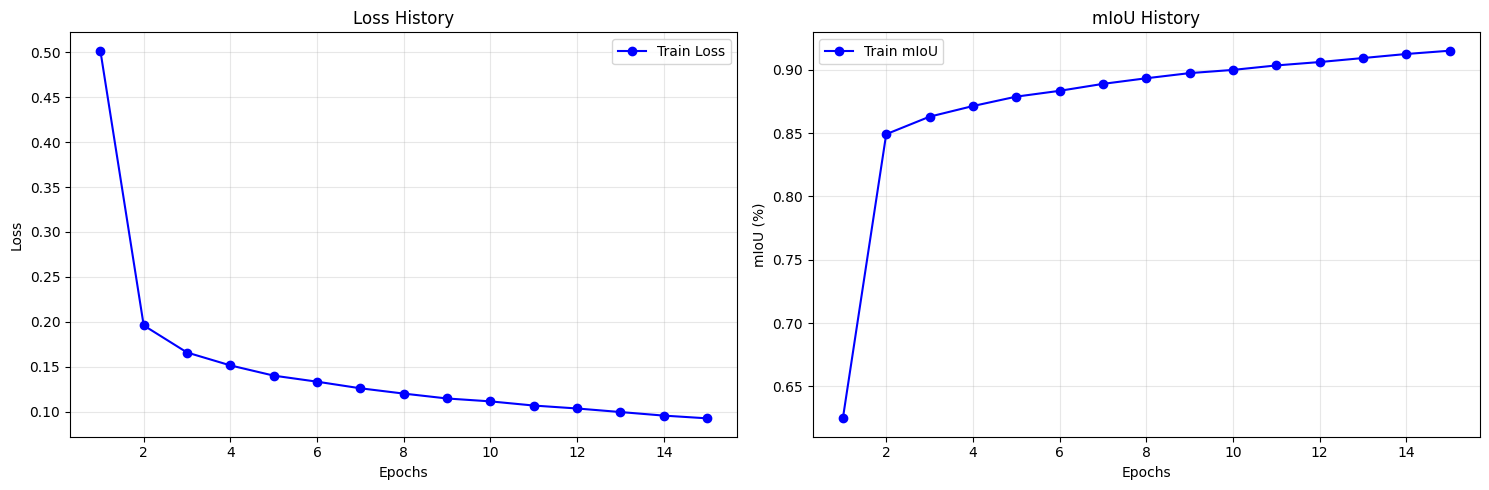

In [129]:
plot_training_history(train_loss= train_loss, train_miou=train_miou)

In [132]:
path = os.path.join(SAVED_MODELS_PATH, 'Q2_model_2.pth')
torch.save(model_Q2.state_dict(), path)

Running quantitative evaluation...

  QUANTITATIVE RESULTS
  Pixel Accuracy   : 99.54%
  IoU (person)     : 78.75%
  IoU (background) : 99.54%
  mIoU             : 89.14%
  Confusion Matrix
    TP=452,128  FP=64,365
    FN=57,664  TN=26,164,531

Running qualitative evaluation...
Qualitative plot saved → ../outputs/q2/qualitative_evaluation_2.png


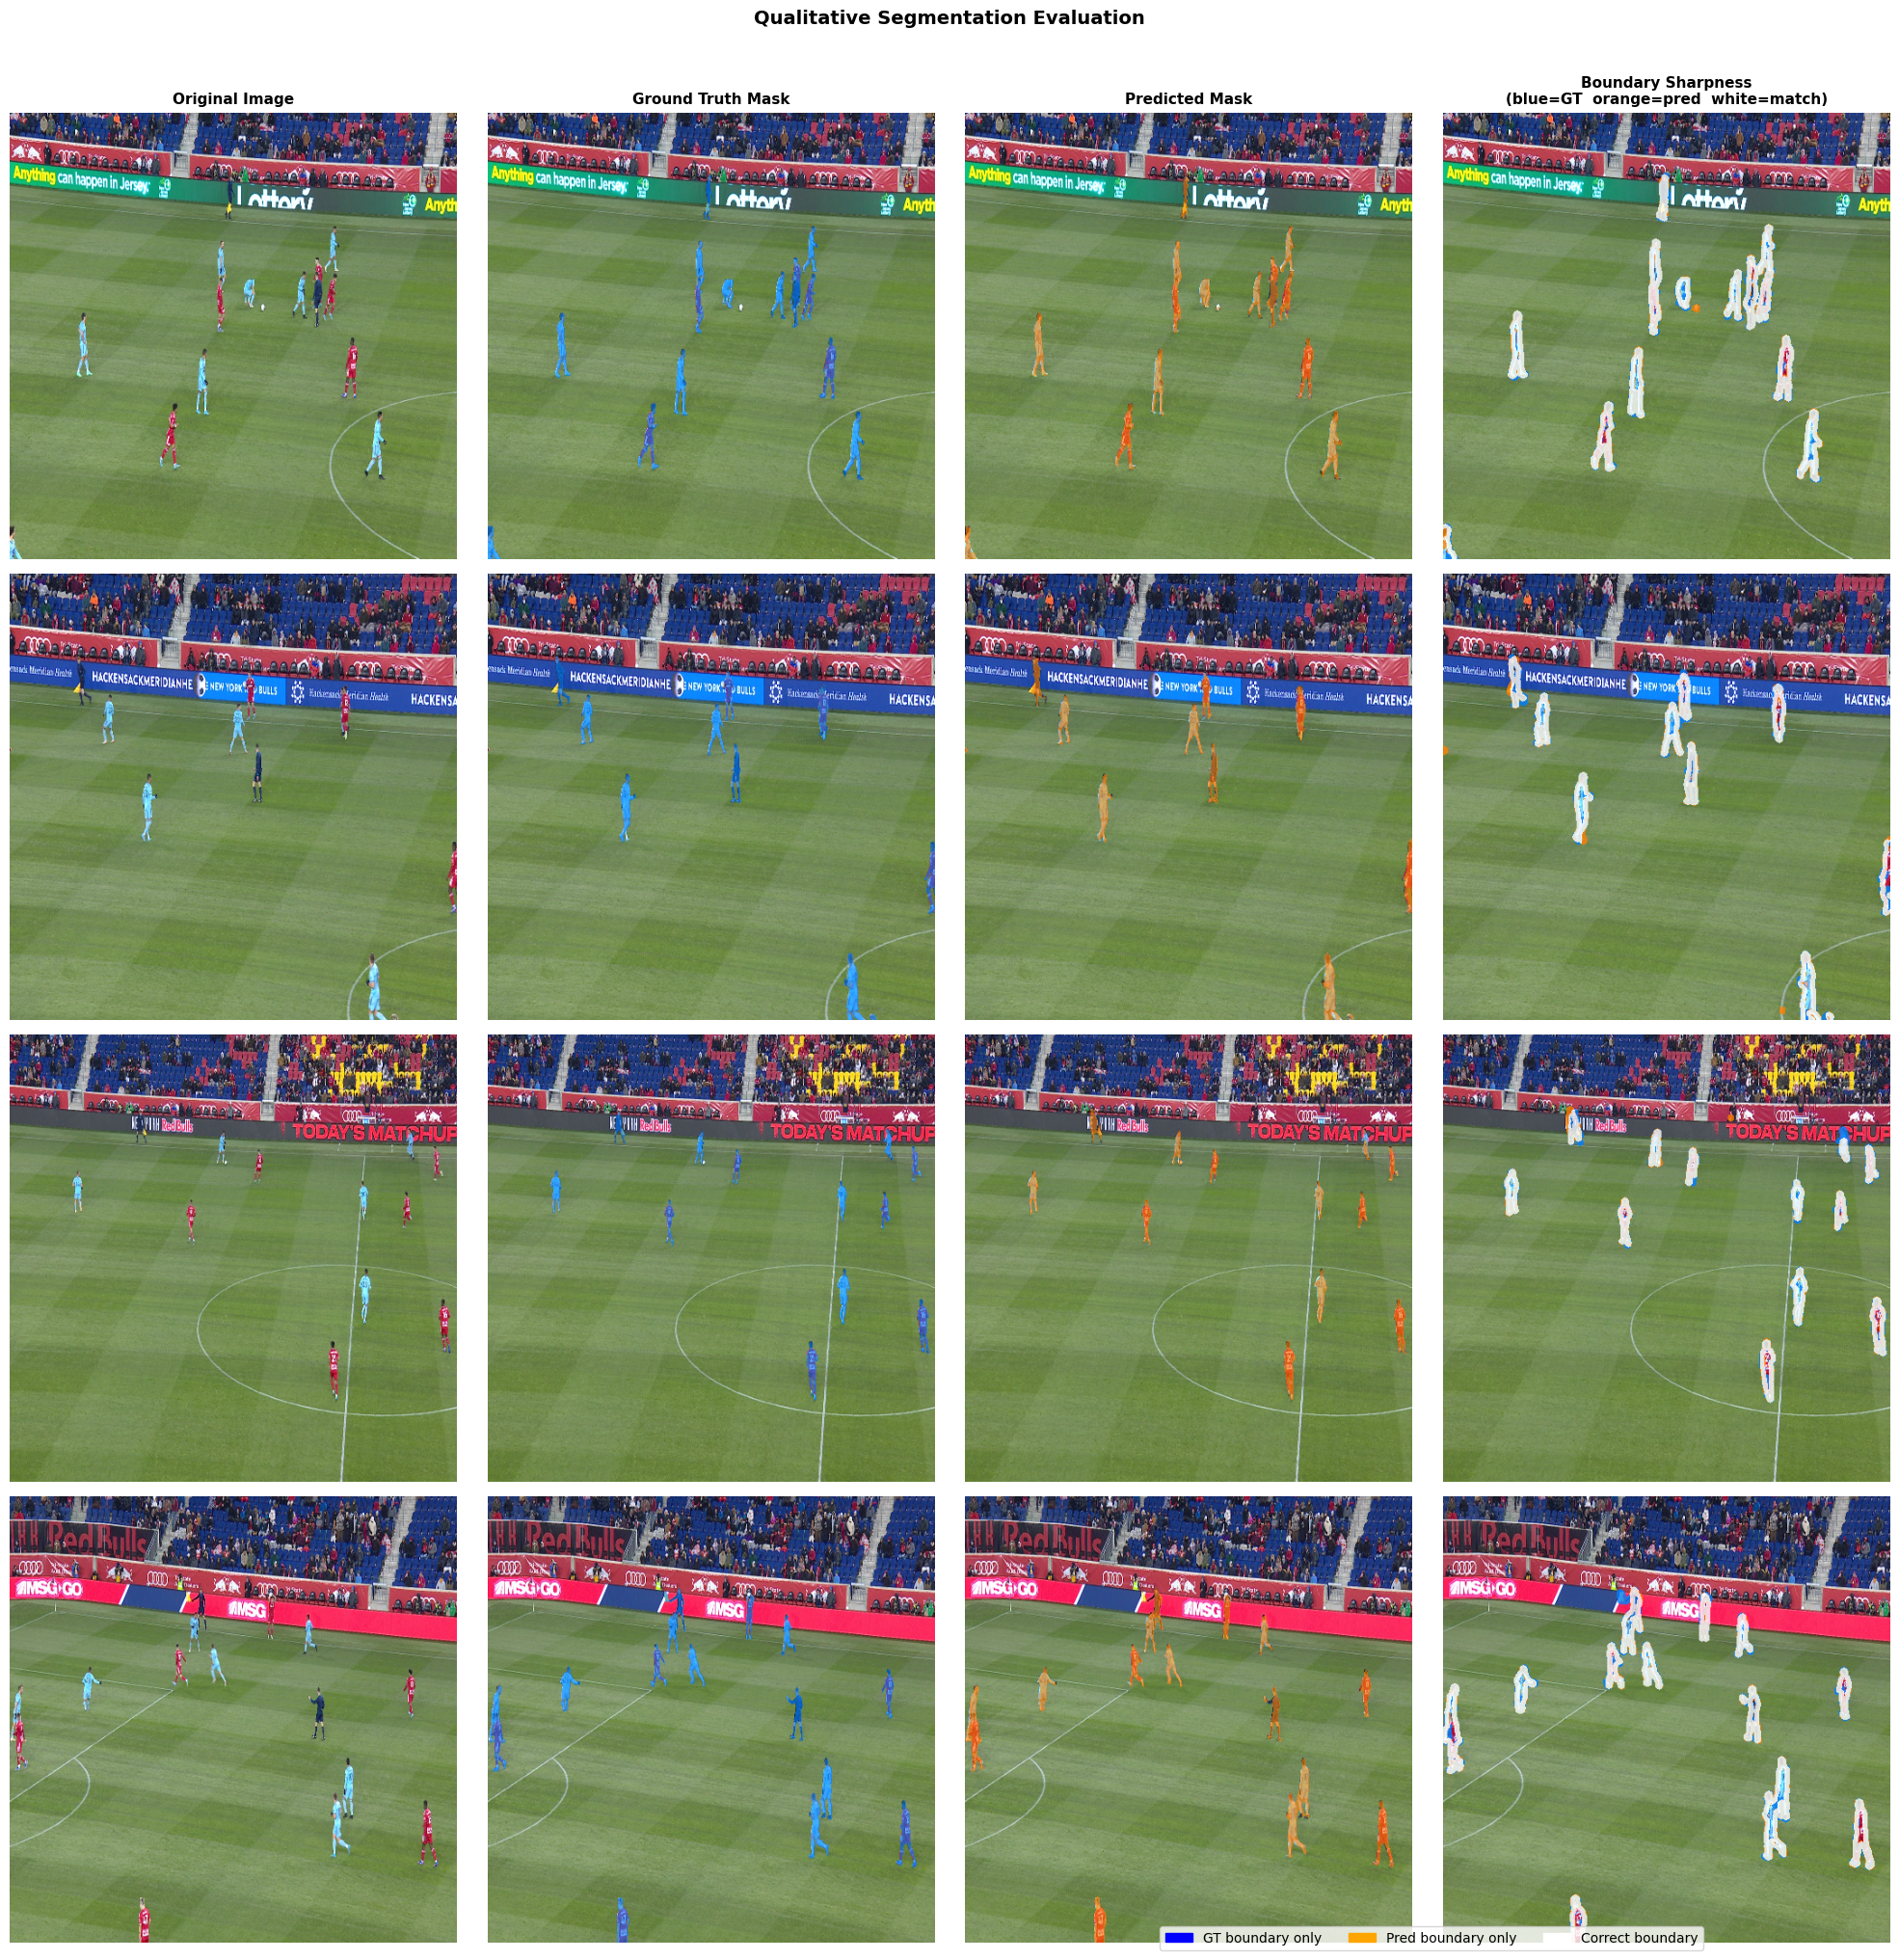

In [150]:
metrics = run_full_evaluation(model_Q2, test_loader, device, num_qualitative_samples=4, save_file_name="qualitative_evaluation_2.png")